# Week 6 Homework

---




## Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution) (normal)-(half normal)-(discrete uniform)" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metropolis cleanup on aisles one two and three  
(or a slice or adaptive squeeze rejection sampling steps... in place of Metropolis steps)

*Implement the above Metropolis within Gibbs algorithm to sample from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*



### Q1 Answer

Note that all the probabilities defined in the code have been converted into log probabilities for numerical stability (and because it was requested).

**Log Priors**

$\log p(\mu \mid \mu_0, \tau_0) = \frac{1}{2}\log\!\left(\frac{\tau_0}{2\pi}\right) - \frac{\tau_0}{2} (\mu-\mu_0)^2$.

$\log p(\sigma^2 \mid \sigma_0^2) = \frac{1}{2}\log\!\left(\frac{2}{\pi \sigma_0^2}\right) - \frac{(\sigma^2)^2}{2\sigma_0^2}$ for  $\sigma^2 > 0$ and $- \infty$ otherwise (the non-log probability is 0).

$\log p(\nu) = \log\!\left(\frac{1}{100}\right) = -\log(100)$ for $\nu \in \{1,\dots,100\}$ and $-\infty$ otherwise.

**Log Likelihood**
$$
\log p(x\mid \mu,\sigma^2,\nu) = \sum_{i=1}^{n}\Biggl[
\log \Gamma\!\left(\frac{\nu+1}{2}\right)
- \log \Gamma\!\left(\frac{\nu}{2}\right)
- \frac{1}{2}\log\big(\pi\,\nu\,\sigma^2\big)
- \frac{\nu+1}{2}\,\log\!\left(1+\frac{1}{\nu}\frac{(x_i-\mu)^2}{\sigma^2}\right)
\Biggr]$$

**Log Posterior**

The overall log posterior (up to an additive constant) is

\begin{aligned}
\log p(\mu,\sigma^2,\nu\mid x) \propto\;& \sum_{i=1}^{n}\Biggl[
\log \Gamma\!\left(\frac{\nu+1}{2}\right)
- \log \Gamma\!\left(\frac{\nu}{2}\right)
- \frac{1}{2}\log\big(\pi\,\nu\,\sigma^2\big)\\[1mm]
&\quad - \frac{\nu+1}{2}\,\log\!\left(1+\frac{1}{\nu}\frac{(x_i-\mu)^2}{\sigma^2}\right)
\Biggr]\\[1mm]
& + \frac{1}{2}\log\!\left(\frac{\tau_0}{2\pi}\right) - \frac{\tau_0}{2}(\mu-\mu_0)^2\\[1mm]
& + \frac{1}{2}\log\!\left(\frac{2}{\pi\sigma_0^2}\right) - \frac{(\sigma^2)^2}{2\sigma_0^2}\\[1mm]
& -\log(100).
\end{aligned}

I will implement this below, firstly with a more standard Metropolis within Gibbs and secondly with HMC for the continuous parameters instead of a regular Metropolis update:


In [3]:
import numpy as np
import scipy.stats as stats
from scipy.special import gammaln
import matplotlib.pyplot as plt

In [4]:
np.random.seed(3650)

# ----- Data Generation -----
n = 100
mu_true = 0.0
sigma2_true = 1.0  # variance parameter (so scale = sqrt(sigma2))
nu_true = 5        # degrees of freedom

data = stats.t(df=nu_true, loc=mu_true, scale=np.sqrt(sigma2_true)).rvs(n)

# ----- Hyperparameters -----
mu0 = 0.0
tau0 = 1.0      # precision for mu prior

sigma0_sq = 1.0  # hyperparameter for the half-normal prior on sigma^2

# nu is discrete uniform over {1, ..., 100}
nu_min, nu_max = 1, 100

# ----- MCMC Settings -----
iterations = 10000

# Initialize storage arrays
mu_samples = np.zeros(iterations)
sigma2_samples = np.zeros(iterations)
nu_samples = np.zeros(iterations, dtype=int)

# Choose good initial parameter values
mu_current = np.mean(data)
sigma2_current = 2
nu_current = 50  # arbitrary starting value in {1,...,100}

# Proposal standard deviations
prop_sd_mu = 0.5
prop_sd_sigma2 = 1
# For nu, we propose a change of ±1 with equal probability.


# ----- Define Log Densities -----
def log_likelihood(mu, sigma2, nu, data):
    """
    Log likelihood for data under a location-scale-t model.
    """
    n = len(data)
    term1 = n * gammaln((nu+1)/2) - n * gammaln(nu/2)
    term2 = - (n/2) * np.log(np.pi * nu * sigma2)
    term3 = - ((nu+1)/2) * np.sum(np.log(1 + ((data - mu)**2) / (nu * sigma2)))
    return term1 + term2 + term3

def log_prior_mu(mu, mu0, tau0):
    # log density for a normal prior on mu:
    return 0.5 * np.log(tau0/(2*np.pi)) - (tau0/2) * (mu - mu0)**2

def log_prior_sigma2(sigma2, sigma0_sq):
    # Half-normal on sigma^2. Return -inf if sigma2 is not positive.
    if sigma2 <= 0:
        return -np.inf
    return 0.5 * np.log(2/(np.pi * sigma0_sq)) - (sigma2**2)/(2*sigma0_sq)

def log_prior_nu(nu, nu_min, nu_max):
    # Discrete uniform over {nu_min, ..., nu_max}. set nu_min and nu_max to 1, 100
    if nu < nu_min or nu > nu_max:
        return -np.inf
    return -np.log(nu_max - nu_min + 1)

def log_posterior(mu, sigma2, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max):
    return (log_likelihood(mu, sigma2, nu, data) +
            log_prior_mu(mu, mu0, tau0) +
            log_prior_sigma2(sigma2, sigma0_sq) +
            log_prior_nu(nu, nu_min, nu_max))


Some plots for the priors:

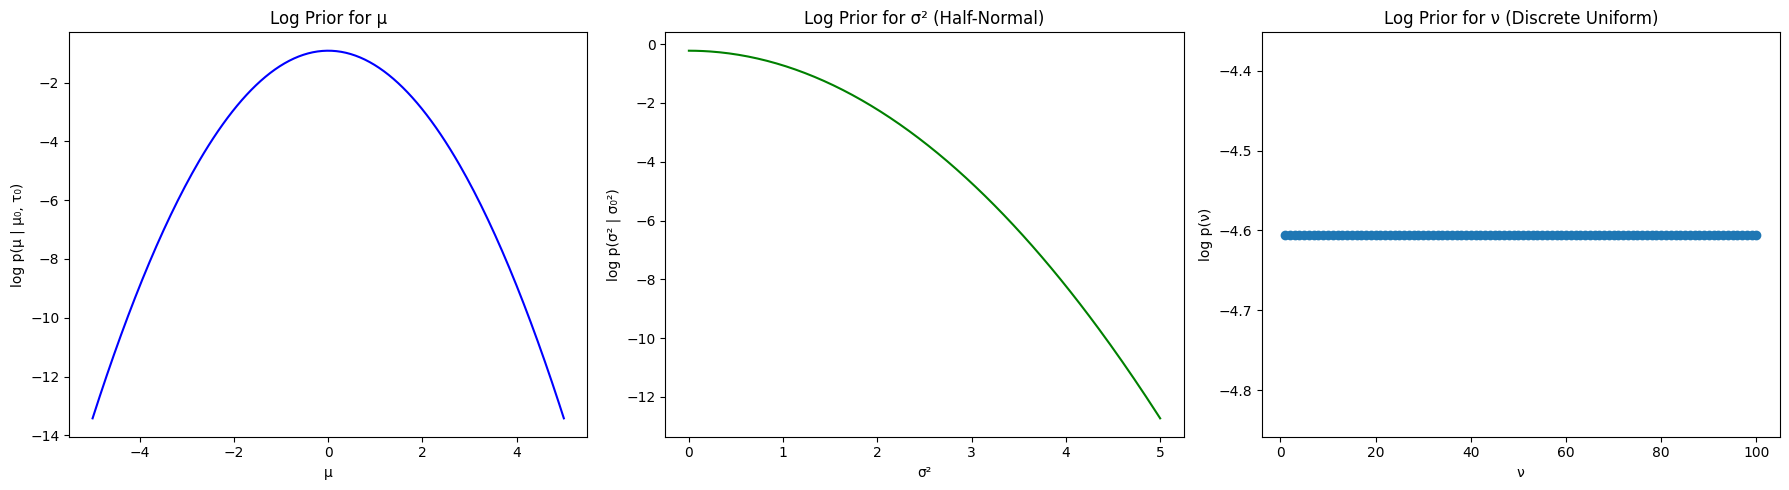

In [5]:
# (A) Log Prior for mu:  plot over a range around mu0
mu_vals = np.linspace(-5, 5, 200)
log_prior_mu_vals = log_prior_mu(mu_vals, mu0, tau0)

# (B) Log Prior for sigma^2 (Half-Normal):
# We plot for positive sigma^2 values. Avoid sigma^2 = 0.
sigma2_vals = np.linspace(0.001, 5, 200)
log_prior_sigma2_vals = np.array([log_prior_sigma2(s, sigma0_sq) for s in sigma2_vals])

# (C) Log Prior for nu (Discrete Uniform):
# nu is discrete so we simply compute it for each valid integer.
nu_vals = [i for i in range(0, 101)]
log_prior_nu_vals = np.array([log_prior_nu(nu, nu_min, nu_max) for nu in range(0, 101)])

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot log_prior_mu
ax[0].plot(mu_vals, log_prior_mu_vals, 'b-')
ax[0].set_title("Log Prior for μ")
ax[0].set_xlabel("μ")
ax[0].set_ylabel("log p(μ | μ₀, τ₀)")

# Plot log_prior_sigma2
ax[1].plot(sigma2_vals, log_prior_sigma2_vals, 'g-')
ax[1].set_title("Log Prior for σ² (Half-Normal)")
ax[1].set_xlabel("σ²")
ax[1].set_ylabel("log p(σ² | σ₀²)")

# Plot log_prior_nu using a stem plot (discrete values)
ax[2].scatter(nu_vals, log_prior_nu_vals)
ax[2].set_title("Log Prior for ν (Discrete Uniform)")
ax[2].set_xlabel("ν")
ax[2].set_ylabel("log p(ν)")

plt.tight_layout()
plt.show()

#### Standard Metropolis within Gibbs

In [6]:
# ----- MCMC Loop -----

# Compute initial log posterior
logpost_current = log_posterior(mu_current, sigma2_current, nu_current,
                                data, mu0, tau0, sigma0_sq, nu_min, nu_max)

# Counters for acceptance rates
accept_mu = 0
accept_sigma2 = 0
accept_nu = 0

for i in range(iterations):
    # --- Update mu ---
    mu_prop = np.random.normal(mu_current, prop_sd_mu)
    logpost_prop = log_posterior(mu_prop, sigma2_current, nu_current,
                                 data, mu0, tau0, sigma0_sq, nu_min, nu_max)
    log_alpha = logpost_prop - logpost_current
    if np.log(np.random.rand()) < log_alpha:
        mu_current = mu_prop
        logpost_current = logpost_prop
        accept_mu += 1

    # --- Update sigma^2 ---
    sigma2_prop = stats.halfnorm(scale=prop_sd_sigma2).rvs()

    logpost_prop = log_posterior(mu_current, sigma2_prop, nu_current,
                                data, mu0, tau0, sigma0_sq, nu_min, nu_max)

    # use the half-normal as the proposal but use a different scaling to the prior value
    log_q_prop = log_prior_sigma2(sigma2_prop, prop_sd_sigma2)
    log_q_current = log_prior_sigma2(sigma2_current, prop_sd_sigma2)

    # Log acceptance prob includes the ratio of proposal densities
    log_alpha = logpost_prop - logpost_current + log_q_current - log_q_prop

    if np.log(np.random.rand()) < log_alpha:
        sigma2_current = sigma2_prop
        logpost_current = logpost_prop
        accept_sigma2 += 1

    # --- Update nu with a discrete random walk ---
    d = np.random.choice([-1, 1])
    nu_prop = nu_current + d

    # Reject moves that go outside the support
    if nu_prop < nu_min or nu_prop > nu_max:
        nu_prop = nu_current
    else:
        logpost_prop = log_posterior(mu_current, sigma2_current, nu_prop,
                                     data, mu0, tau0, sigma0_sq, nu_min, nu_max)
        log_alpha = logpost_prop - logpost_current
        if np.log(np.random.rand()) < log_alpha:
            nu_current = nu_prop
            logpost_current = logpost_prop
            accept_nu += 1

    # Save current samples
    mu_samples[i] = mu_current
    sigma2_samples[i] = sigma2_current
    nu_samples[i] = nu_current

print("Acceptance rates:")
print("mu: {:.3f}".format(accept_mu / iterations))
print("sigma^2: {:.3f}".format(accept_sigma2 / iterations))
print("nu: {:.3f}".format(accept_nu / iterations))


Acceptance rates:
mu: 0.294
sigma^2: 0.231
nu: 0.716


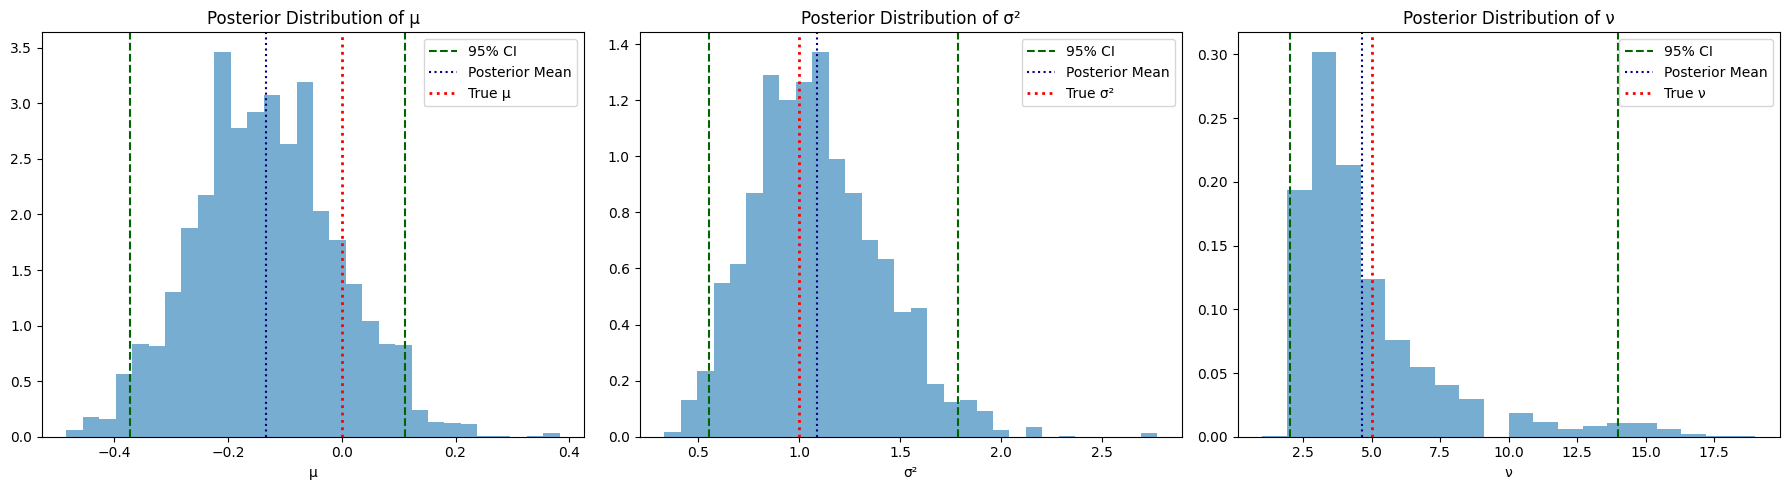

Metropolis-Within-Gibbs Bayesian Inference Results (n = 100):
True population mean (μ): 0.00
95% Credible Interval for μ: [-0.37, 0.11]
Posterior mean for μ: -0.13

True population variance (σ²): 1.00
95% Credible Interval for σ²: [0.55, 1.79]
Posterior mean for σ²: 1.09

True degrees of freedom (ν): 5.00
95% Credible Interval for ν: [2.00, 14.00]
Posterior mean for ν: 4.65


In [7]:
# ----- Bayesian Inference: Compute Posterior Summaries & 95% Credible Intervals -----

# Discard burn-in samples
burn_in = 5000
mu_samples_post = mu_samples[burn_in:]
sigma2_samples_post = sigma2_samples[burn_in:]
nu_samples_post = nu_samples[burn_in:]

# Compute 95% credible intervals
mu_ci = np.quantile(mu_samples_post, [0.025, 0.975])
sigma2_ci = np.quantile(sigma2_samples_post, [0.025, 0.975])
nu_ci = np.quantile(nu_samples_post, [0.025, 0.975])

# Posterior summaries and plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Posterior for μ
axs[0].hist(mu_samples_post, bins=30, density=True, alpha=0.6)
axs[0].axvline(mu_ci[0], color="darkgreen", linestyle="--", label="95% CI")
axs[0].axvline(mu_ci[1], color="darkgreen", linestyle="--")
axs[0].axvline(mu_samples_post.mean(), color="navy", linestyle=":", label="Posterior Mean")
axs[0].axvline(mu_true, color="red", linestyle=":", linewidth=2, label="True μ")
axs[0].set_title("Posterior Distribution of μ")
axs[0].set_xlabel("μ")
axs[0].legend()

# Posterior for σ²
axs[1].hist(sigma2_samples_post, bins=30, density=True, alpha=0.6)
axs[1].axvline(sigma2_ci[0], color="darkgreen", linestyle="--", label="95% CI")
axs[1].axvline(sigma2_ci[1], color="darkgreen", linestyle="--")
axs[1].axvline(sigma2_samples_post.mean(), color="navy", linestyle=":", label="Posterior Mean")
axs[1].axvline(sigma2_true, color="red", linestyle=":", linewidth=2, label="True σ²")
axs[1].set_title("Posterior Distribution of σ²")
axs[1].set_xlabel("σ²")
axs[1].legend()

# Posterior for ν (discrete)
axs[2].hist(nu_samples_post, bins=20, density=True, alpha=0.6)
axs[2].axvline(nu_ci[0], color="darkgreen", linestyle="--", label="95% CI")
axs[2].axvline(nu_ci[1], color="darkgreen", linestyle="--")
axs[2].axvline(nu_samples_post.mean(), color="navy", linestyle=":", label="Posterior Mean")
axs[2].axvline(nu_true, color="red", linestyle=":", linewidth=2, label="True ν")
axs[2].set_title("Posterior Distribution of ν")
axs[2].set_xlabel("ν")
axs[2].legend()

plt.tight_layout()
plt.show()

# Print posterior summaries
print(f"Metropolis-Within-Gibbs Bayesian Inference Results (n = {n}):")
print("====================================")
print(f"True population mean (μ): {mu_true:.2f}")
print(f"95% Credible Interval for μ: [{mu_ci[0]:.2f}, {mu_ci[1]:.2f}]")
print(f"Posterior mean for μ: {mu_samples_post.mean():.2f}")
print()
print(f"True population variance (σ²): {sigma2_true:.2f}")
print(f"95% Credible Interval for σ²: [{sigma2_ci[0]:.2f}, {sigma2_ci[1]:.2f}]")
print(f"Posterior mean for σ²: {sigma2_samples_post.mean():.2f}")
print()
print(f"True degrees of freedom (ν): {nu_true:.2f}")
print(f"95% Credible Interval for ν: [{nu_ci[0]:.2f}, {nu_ci[1]:.2f}]")
print(f"Posterior mean for ν: {nu_samples_post.mean():.2f}")

#### Hamiltonian Monte Carlo for Q1

Using HMC for the continuous parameters $\mu, \sigma^2$ and just Metropolis for the discrete parameter $\nu$.

HMC acceptance rate for (μ, s): 0.9997
Acceptance rate for ν: 0.6716


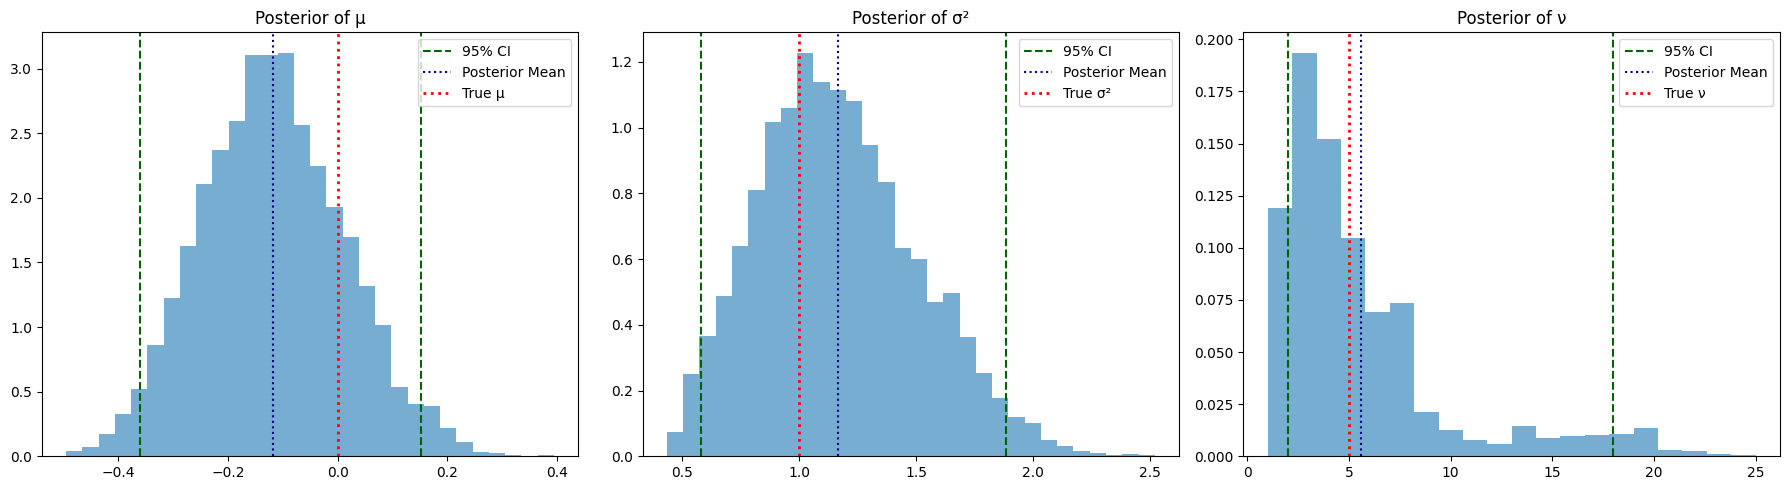

HMC Metropolis-Within-Gibbs Bayesian Inference Results (n = 100):
True population mean (μ): 0.00
95% Credible Interval for μ: [-0.36, 0.15]
Posterior mean for μ: -0.12

True population variance (σ²): 1.00
95% Credible Interval for σ²: [0.58, 1.88]
Posterior mean for σ²: 1.17

True degrees of freedom (ν): 5.00
95% Credible Interval for ν: [2.00, 18.00]
Posterior mean for ν: 5.57


In [8]:
# Original log density functions for the model:
def log_likelihood(mu, sigma2, nu, data):
    n = len(data)
    term1 = n * gammaln((nu+1)/2) - n * gammaln(nu/2)
    term2 = - (n/2) * np.log(np.pi * nu * sigma2)
    term3 = - ((nu+1)/2) * np.sum(np.log(1 + ((data - mu)**2) / (nu * sigma2)))
    return term1 + term2 + term3

def log_prior_mu(mu, mu0, tau0):
    return 0.5 * np.log(tau0/(2*np.pi)) - (tau0/2) * (mu - mu0)**2

def log_prior_sigma2(sigma2, sigma0_sq):
    if sigma2 <= 0:
        return -np.inf
    return 0.5 * np.log(2/(np.pi * sigma0_sq)) - (sigma2**2)/(2*sigma0_sq)

def log_prior_nu(nu, nu_min, nu_max):
    if nu < nu_min or nu > nu_max:
        return -np.inf
    return -np.log(nu_max - nu_min + 1)

def log_posterior(mu, sigma2, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max):
    return (log_likelihood(mu, sigma2, nu, data) +
            log_prior_mu(mu, mu0, tau0) +
            log_prior_sigma2(sigma2, sigma0_sq) +
            log_prior_nu(nu, nu_min, nu_max))

# ---------------------------------------------------------------------
# We now reparameterize sigma2 by letting s = log(sigma2), so sigma2 = exp(s).
# The transformed log density for the continuous block (mu, s) is then:
def log_post_cont(mu, s, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max):
    sigma2 = np.exp(s)
    # Add the Jacobian term (+ s) for the change of variable:
    return log_posterior(mu, sigma2, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max) + s

# ---------------------------------------------------------------------
# A helper function to compute gradients via finite differences.
def grad_log_post_cont(mu, s, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max, eps=1e-6):
    grad = np.zeros(2)
    f0 = log_post_cont(mu, s, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
    # Derivative w.r.t. mu:
    f_plus = log_post_cont(mu+eps, s, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
    f_minus = log_post_cont(mu-eps, s, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
    grad[0] = (f_plus - f_minus) / (2*eps)
    # Derivative w.r.t. s:
    f_plus = log_post_cont(mu, s+eps, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
    f_minus = log_post_cont(mu, s-eps, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
    grad[1] = (f_plus - f_minus) / (2*eps)
    return grad

# ---------------------------------------------------------------------
# HMC update for the continuous block (mu, s) given fixed nu.
def hmc_update(mu_current, s_current, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max,
               hmc_eps=0.01, L=10):
    current_pos = np.array([mu_current, s_current])
    current_log_post = log_post_cont(mu_current, s_current, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
    current_grad = grad_log_post_cont(mu_current, s_current, nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max)

    # Sample momentum from a standard normal:
    p_current = np.random.randn(2)
    current_H = -current_log_post + 0.5 * np.sum(p_current**2)

    # Initialize proposal variables:
    pos = current_pos.copy()
    p = p_current.copy()

    # Leapfrog integration:
    p = p + 0.5 * hmc_eps * grad_log_post_cont(pos[0], pos[1], nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
    for i in range(L):
        pos = pos + hmc_eps * p
        if i != L-1:
            p = p + hmc_eps * grad_log_post_cont(pos[0], pos[1], nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
    p = p + 0.5 * hmc_eps * grad_log_post_cont(pos[0], pos[1], nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
    p = -p  # Reverse momentum for reversibility.

    proposed_log_post = log_post_cont(pos[0], pos[1], nu, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
    proposed_H = -proposed_log_post + 0.5 * np.sum(p**2)

    accept_prob = np.exp(current_H - proposed_H)
    if np.random.rand() < accept_prob:
        return pos[0], pos[1], True
    else:
        return mu_current, s_current, False

# ---------------------------------------------------------------------
# Now, combine the HMC update for the continuous block with a discrete update for ν.
# (This is the hybrid sampler: HMC for (μ, s) and Metropolis for ν.)
np.random.seed(3650)

# Storage for samples:
mu_samples = np.zeros(iterations)
s_samples = np.zeros(iterations)  # s = log(σ²)
nu_samples = np.zeros(iterations, dtype=int)

# Initialize:
mu_current = np.mean(data)
sigma2_current = 2.0
s_current = np.log(sigma2_current)
nu_current = 10

# HMC settings for continuous update:
hmc_eps = 0.01
L = 10

accept_hmc = 0
accept_nu = 0

for i in range(iterations):
    # --- Update (μ, s) using HMC (with ν fixed) ---
    mu_current, s_current, accepted = hmc_update(mu_current, s_current, nu_current,
                                                 data, mu0, tau0, sigma0_sq, nu_min, nu_max,
                                                 hmc_eps, L)
    if accepted:
        accept_hmc += 1

    # --- Update ν using a discrete random walk ---
    d = np.random.choice([-1, 1])
    nu_prop = nu_current + d
    if nu_prop < nu_min or nu_prop > nu_max:
        nu_prop = nu_current
    else:
        logpost_current = log_post_cont(mu_current, s_current, nu_current, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
        logpost_prop = log_post_cont(mu_current, s_current, nu_prop, data, mu0, tau0, sigma0_sq, nu_min, nu_max)
        if np.log(np.random.rand()) < (logpost_prop - logpost_current):
            nu_current = nu_prop
            accept_nu += 1

    # Save samples:
    mu_samples[i] = mu_current
    s_samples[i] = s_current
    nu_samples[i] = nu_current

# Convert s_samples to σ² samples:
sigma2_samples = np.exp(s_samples)

print("HMC acceptance rate for (μ, s):", accept_hmc / iterations)
print("Acceptance rate for ν:", accept_nu / iterations)

# ---------------------------------------------------------------------
# Posterior summaries (discarding burn-in):
burn_in = 5000
mu_post = mu_samples[burn_in:]
sigma2_post = sigma2_samples[burn_in:]
nu_post = nu_samples[burn_in:]

mu_ci = np.quantile(mu_post, [0.025, 0.975])
sigma2_ci = np.quantile(sigma2_post, [0.025, 0.975])
nu_ci = np.quantile(nu_post, [0.025, 0.975])

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].hist(mu_post, bins=30, density=True, alpha=0.6)
axs[0].axvline(mu_ci[0], color="darkgreen", linestyle="--", label="95% CI")
axs[0].axvline(mu_ci[1], color="darkgreen", linestyle="--")
axs[0].axvline(mu_post.mean(), color="navy", linestyle=":", label="Posterior Mean")
axs[0].axvline(mu_true, color="red", linestyle=":", linewidth=2, label="True μ")
axs[0].set_title("Posterior of μ")
axs[0].legend()

axs[1].hist(sigma2_post, bins=30, density=True, alpha=0.6)
axs[1].axvline(sigma2_ci[0], color="darkgreen", linestyle="--", label="95% CI")
axs[1].axvline(sigma2_ci[1], color="darkgreen", linestyle="--")
axs[1].axvline(sigma2_post.mean(), color="navy", linestyle=":", label="Posterior Mean")
axs[1].axvline(sigma2_true, color="red", linestyle=":", linewidth=2, label="True σ²")
axs[1].set_title("Posterior of σ²")
axs[1].legend()

axs[2].hist(nu_post, bins=20, density=True, alpha=0.6)
axs[2].axvline(nu_ci[0], color="darkgreen", linestyle="--", label="95% CI")
axs[2].axvline(nu_ci[1], color="darkgreen", linestyle="--")
axs[2].axvline(nu_post.mean(), color="navy", linestyle=":", label="Posterior Mean")
axs[2].axvline(nu_true, color="red", linestyle=":", linewidth=2, label="True ν")
axs[2].set_title("Posterior of ν")
axs[2].legend()

plt.tight_layout()
plt.show()


# Print posterior summaries
print(f"HMC Metropolis-Within-Gibbs Bayesian Inference Results (n = {n}):")
print("====================================")
print(f"True population mean (μ): {mu_true:.2f}")
print(f"95% Credible Interval for μ: [{mu_ci[0]:.2f}, {mu_ci[1]:.2f}]")
print(f"Posterior mean for μ: {mu_post.mean():.2f}")
print()
print(f"True population variance (σ²): {sigma2_true:.2f}")
print(f"95% Credible Interval for σ²: [{sigma2_ci[0]:.2f}, {sigma2_ci[1]:.2f}]")
print(f"Posterior mean for σ²: {sigma2_post.mean():.2f}")
print()
print(f"True degrees of freedom (ν): {nu_true:.2f}")
print(f"95% Credible Interval for ν: [{nu_ci[0]:.2f}, {nu_ci[1]:.2f}]")
print(f"Posterior mean for ν: {nu_post.mean():.2f}")

## Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

### Q2 Answer

In [9]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

In [10]:
# Sample sizes to explore
sample_sizes = [30, 100, 500, 1000]

# Dictionary to store traces for each sample size
traces = {}
summaries = {}

# Loop over different sample sizes
for n in sample_sizes:
    # Simulate data from a Student's t distribution
    # using the standard_t function, then rescale and shift.
    data = np.random.standard_t(df=nu_true, size=n) * np.sqrt(sigma2_true) + mu_true

    with pm.Model() as model:
        # Prior for mu: Normal(mu0, 1/sqrt(tau0))
        mu = pm.Normal("mu", mu=mu0, tau=tau0)

        # Prior for sigma^2 using a half-normal density.
        sigma2 = pm.HalfNormal("sigma2", sigma=sigma0_sq)

        # Prior for nu: Discrete uniform over {nu_min, ..., nu_max}
        nu = pm.DiscreteUniform("nu", lower=nu_min, upper=nu_max)

        # Likelihood: Student's t distribution.
        # Note: pm.StudentT is parameterized with nu (degrees of freedom), mu (location),
        # and sigma (scale), so we set sigma = sqrt(sigma2).
        x = pm.StudentT("x", nu=nu, mu=mu, sigma=pm.math.sqrt(sigma2), observed=data)

        # Sample from the posterior.
        trace = pm.sample(2000, tune=1000, target_accept=0.9,
                          return_inferencedata=True, chains=2)

    traces[n] = trace
    summary = az.summary(trace, hdi_prob=0.95)
    summaries[n] = summary
    print(f"Completed sampling for n = {n}")
    print(summary)
    print("\n" + "="*80 + "\n")


Output()

Completed sampling for n = 30
          mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu       0.215   0.250    -0.283      0.691      0.004    0.003    3242.0   
nu      50.260  28.043     8.000     99.000      1.023    0.724     725.0   
sigma2   1.790   0.398     1.055      2.579      0.007    0.005    2866.0   

        ess_tail  r_hat  
mu        2430.0    1.0  
nu         738.0    1.0  
sigma2    1964.0    1.0  




Output()

Completed sampling for n = 100
          mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu      -0.063   0.136    -0.321      0.204      0.003    0.002    2658.0   
nu      47.614  28.417     4.000     96.000      1.255    0.888     473.0   
sigma2   1.773   0.273     1.268      2.341      0.007    0.005    1335.0   

        ess_tail  r_hat  
mu        2413.0   1.00  
nu         270.0   1.01  
sigma2    1036.0   1.00  




Output()

Completed sampling for n = 500
         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu      0.071  0.054    -0.033      0.174      0.001    0.001    1966.0   
nu      6.252  1.695     4.000      9.000      0.113    0.080     230.0   
sigma2  1.097  0.109     0.897      1.319      0.005    0.004     435.0   

        ess_tail  r_hat  
mu        2273.0   1.00  
nu         200.0   1.01  
sigma2     989.0   1.00  




Output()

Completed sampling for n = 1000
         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     -0.039  0.037    -0.112      0.035      0.001    0.001    3057.0   
nu      4.811  0.752     4.000      6.000      0.041    0.029     332.0   
sigma2  1.024  0.080     0.874      1.182      0.003    0.002     568.0   

        ess_tail  r_hat  
mu        2206.0   1.00  
nu         357.0   1.01  
sigma2    1340.0   1.00  




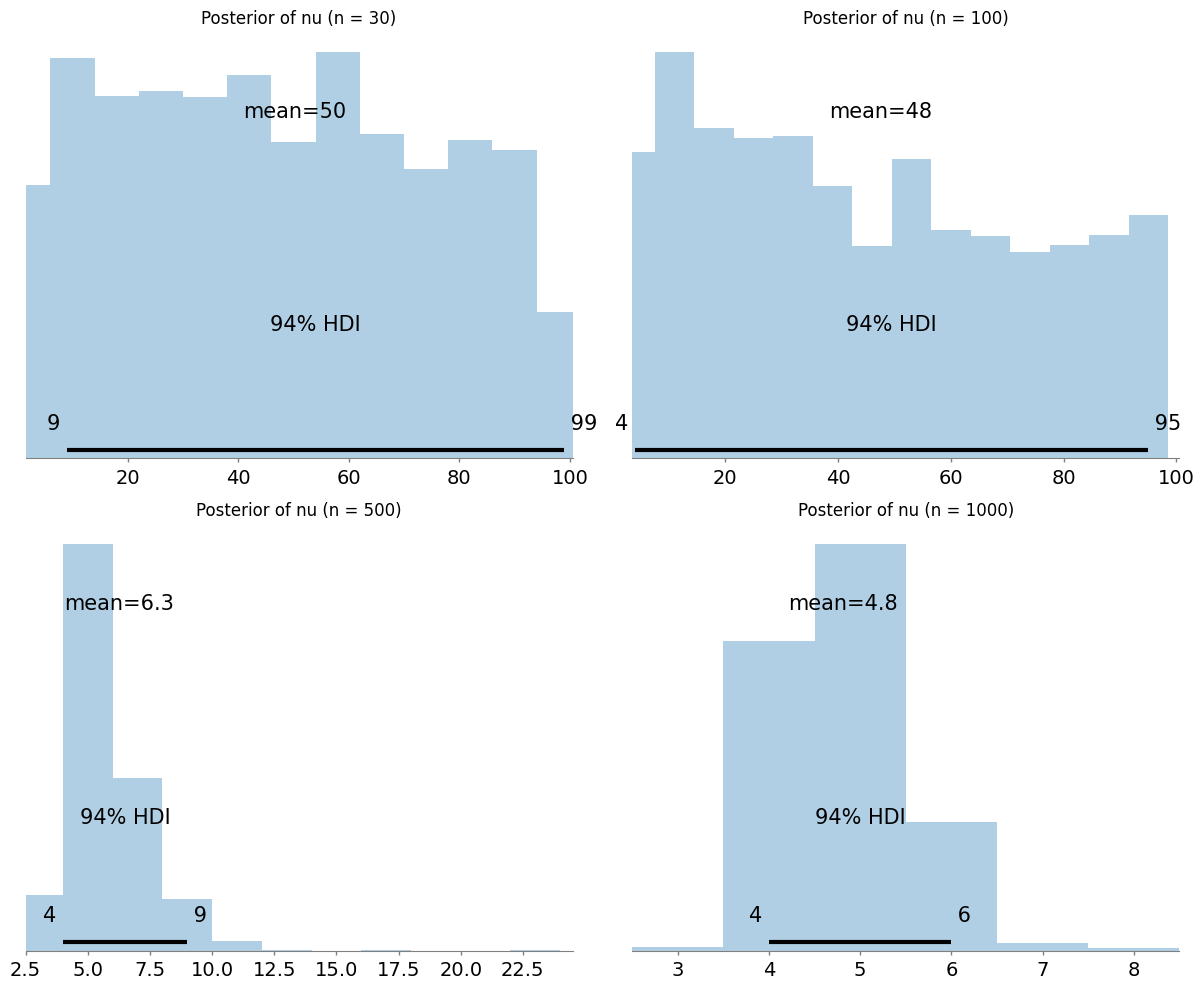

In [11]:
# -----------------------------
# Plot the posterior distribution for nu across different sample sizes.
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for ax, n in zip(axs, sample_sizes):
    az.plot_posterior(traces[n], var_names=['nu'], ax=ax)
    ax.set_title(f"Posterior of nu (n = {n})")

plt.tight_layout()
plt.show()

**Summary:** With limited data, the posterior over $\nu$ tends to be diffuse. The evidence to distinguish heavy tails from a normal model is weak, resulting in high uncertainty in the inferred value of $\nu$. Our credible intervals are wider and the samples are more uniformly spread out over a range of values.

As the sample size increases, more information is available about the tail behavior. Consequently, the posterior over $\nu$ becomes more concentrated and peaks closer to the true value of $\nu^* = 5$. With more data, we are better able to infer the correct value of the degrees of freedom $\nu$; our credible intervals are much narrower and the drawn samples concentrate around the true value.

TLDR; as the sample size grows, the inference sharpens, and the posterior over $\nu$ more reliably recovers the true underlying degrees of freedom.

## Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{Gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \beta = \frac{\nu}{2}\big)$ where $\beta$ is the rate parameter for the Gamma distribution, and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$. Now, integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t-distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analogous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



### Q3 Answer

We begin with the given expressions. First, using the definition of the Normal from Q1, we have

Likelihood $p(y_i \mid \tau_i) = \sqrt{\frac{\tau_i}{2\pi}}\,\exp\!\left(-\frac{1}{2}\tau_i y_i^2\right)$

Prior $p(\tau_i) = \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma\!\left(\frac{\nu}{2}\right)}\, \tau_i^{\frac{\nu}{2}-1} \exp\!\left(-\frac{\nu}{2}\tau_i\right).$

Thus, the marginal density for $y_i$ is

\begin{aligned}
p(y_i) &= \int p(y_i \mid \tau_i) \, p(\tau_i) \, d\tau_i \\
&= \int \sqrt{\frac{\tau_i}{2\pi}}\,\exp\!\left(-\frac{1}{2}\tau_i y_i^2\right) \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma\!\left(\frac{\nu}{2}\right)}\, \tau_i^{\frac{\nu}{2}-1}\,\exp\!\left(-\frac{\nu}{2}\tau_i\right) d\tau_i\\
&=\frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma\!\left(\frac{\nu}{2}\right)}\frac{1}{\sqrt{2\pi}} \int \tau_i^{\frac{\nu+1}{2}-1} \exp\!\left[-\tau_i\left(\frac{y_i^2+\nu}{2}\right)\right]\,d\tau_i.
\end{aligned}

This is the gamma integral formula:

\begin{aligned}
\int_0^\infty \tau^{a-1}\,e^{-b\tau}\,d\tau = \frac{\Gamma(a)}{b^a},
\end{aligned}

valid for $a > 0$ and $b > 0$. In our integral, we can substitute $a = \frac{\nu+1}{2}$ and $b = \frac{y_i^2+\nu}{2}$.
<!-- - $a = \frac{\nu+1}{2}$,
- $b = \frac{y_i^2+\nu}{2}$. -->

Thus, the integral evaluates to

\begin{aligned}
\int_0^\infty \tau_i^{\frac{\nu+1}{2}-1}\,\exp\!\left[-\tau_i\left(\frac{y_i^2+\nu}{2}\right)\right]\,d\tau_i = \frac{\Gamma\!\left(\frac{\nu+1}{2}\right)}{\left(\frac{y_i^2+\nu}{2}\right)^{\frac{\nu+1}{2}}}.
\end{aligned}

Substitute this back into the expression for $p(y_i)$:

\begin{aligned}
p(y_i) &= \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma\!\left(\frac{\nu}{2}\right)}\frac{1}{\sqrt{2\pi}} \cdot \frac{\Gamma\!\left(\frac{\nu+1}{2}\right)}{\left(\frac{y_i^2+\nu}{2}\right)^{\frac{\nu+1}{2}}}\\
&= \frac{\Gamma\!\left(\frac{\nu+1}{2}\right)}{\Gamma\!\left(\frac{\nu}{2}\right)} \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\sqrt{2\pi}} \left(\frac{2}{y_i^2+\nu}\right)^{\frac{\nu+1}{2}}\\
&= \frac{\Gamma\!\left(\frac{\nu+1}{2}\right)}{\Gamma\!\left(\frac{\nu}{2}\right)} \frac{\nu^{\frac{\nu}{2}}}{2^{\frac{\nu}{2}}\,\sqrt{2\pi}} \cdot \frac{2^{\frac{\nu+1}{2}}}{(y_i^2+\nu)^{\frac{\nu+1}{2}}}\\
&= \frac{\Gamma\!\left(\frac{\nu+1}{2}\right)}{\Gamma\!\left(\frac{\nu}{2}\right)} \frac{\nu^{\frac{\nu}{2}}\,2^{\frac{1}{2}}}{\sqrt{2\pi}\,(y_i^2+\nu)^{\frac{\nu+1}{2}}}\\
&= \frac{\Gamma\!\left(\frac{\nu+1}{2}\right)}{\Gamma\!\left(\frac{\nu}{2}\right)} \frac{\nu^{\frac{\nu}{2}}}{\sqrt{\pi}\,(y_i^2+\nu)^{\frac{\nu+1}{2}}}\\
&=\frac{\Gamma\!\left(\frac{\nu+1}{2}\right)}{\Gamma\!\left(\frac{\nu}{2}\right)} \frac{\nu^{\frac{\nu}{2}}}{\sqrt{\pi}\,\nu^{\frac{\nu+1}{2}}} \left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}}\\
&= \frac{\Gamma\!\left(\frac{\nu+1}{2}\right)}{\sqrt{\nu\pi}\,\Gamma\!\left(\frac{\nu}{2}\right)} \left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}}
\end{aligned}

The final expression

\begin{aligned}
p(y_i) = \frac{\Gamma\!\left(\frac{\nu+1}{2}\right)}{\sqrt{\nu\pi}\,\Gamma\!\left(\frac{\nu}{2}\right)} \left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}}
\end{aligned}

is exactly the probability density function of a Student’s t‑distribution with $\nu$ degrees of freedom, location $0$, and scale $1$.

So, by integrating out $\tau_i$, we have obtained a Student’s t‑distribution for $y_i$. This result shows that even though the conditional model $p(y_i \mid \tau_i)$ is normal, the uncertainty in $\tau_i$ (as expressed by its Gamma prior) leads to a heavier-tailed marginal distribution for $y_i$.

#### **Analogy to the Posterior Predictive Distribution**

When we compute the posterior predictive distribution, we integrate over the uncertainty in the model parameters. That is, rather than using a single point estimate for a parameter, we average the likelihood over the entire posterior distribution of that parameter.
  
Here, the integration over $\tau_i$ is analogous to this process. Although the conditional model for $y_i$ given $\tau_i$ is Normal, the extra uncertainty due to $\tau_i$ leads to a Student's t marginal predictive distribution. This t‑distribution has heavier tails than a normal distribution, reflecting the additional uncertainty about the variance (or precision).

In summary, just as the posterior predictive distribution accounts for uncertainty in the parameters by averaging over them, the integration over $\tau_i$ produces a predictive distribution for $y_i$ that naturally incorporates that uncertainty, resulting in the well-known t‑distribution.


